# Evaluation

The evaluation strategy is as follows. There are 30 classes of images in the RSICD dataset. We construct a synthetic set of captions that use the pattern "An arial photograph of a `class_type`" for each of the 30 classes. We feed each image and the synthetic captions into the model under evaluation, and get back predictions of the best caption associated with the image. We calculate the matches at k for various k=1, 3, 5, 10, and report them.

In [1]:
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import os

from PIL import Image
from transformers import CLIPProcessor, FlaxCLIPModel

Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-bcec0017-w-0.palsujit.log.INFO.20210710-224755.96019': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-bcec0017-w-0.palsujit.log.INFO.20210710-224755.96019': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-bcec0017-w-0.palsujit.log.INFO.20210710-224755.96019': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-bcec0017-w-0.palsujit.log.INFO.20210710-224755.96019': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-bcec0017-w-0.palsujit.log.INFO.20210710-224755.96019': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-bcec0017-w-0.palsujit.log.INFO.20210710-224755.96019': Permission denied
Could not open any log file.
Could not open the log file 

In [2]:
DATA_DIR = "/home/shared/data"

IMAGES_DIR = os.path.join(DATA_DIR, "RSICD_images")
CAPTIONS_FILE = os.path.join(DATA_DIR, "dataset_rsicd.json")

# EVAL_IMAGES_LIST = os.path.join(DATA_DIR, "eval_images.txt")
EVAL_IMAGES_LIST = "eval_images.txt"
EVAL_RESULTS = "eval_results.tsv"

### Data

The RSICD dataset is split into train, val, and test sets of 8734, 1094 and 1093 images with associated captions respectively. 

We will use only the images with the class name in the image file name.

In [3]:
image_filenames = os.listdir(IMAGES_DIR)
len(image_filenames)

10921

In [4]:
image2captions = {}
with open(CAPTIONS_FILE, "r") as fcap:
    data = json.loads(fcap.read())
for image in data["images"]:
    if image["split"] == "test":
        filename = image["filename"]
        if filename.find("_") > 0:
            sentences = []
            for sentence in image["sentences"]:
                sentences.append(sentence["raw"])
            image2captions[filename] = sentences
    
len(image2captions)

1027

filename: airport_348.jpg
sentences: ['the airport is very large .', 'next to the airport is green grass .', 'next to the airport is green grass .', 'the airport is very large .', 'the airport is very large .']


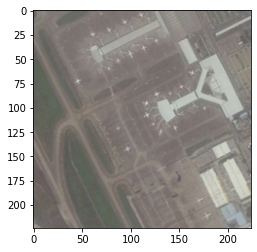

In [5]:
for image_filename in image2captions.keys():
    print("filename:", image_filename)
    image = Image.fromarray(plt.imread(os.path.join(IMAGES_DIR, image_filename)))
    plt.imshow(image)
    print("sentences:", image2captions[image_filename])
    break

### Image Classes from file names

In [6]:
class_types = sorted(list(set([fn.split("_")[0] 
                               for fn in image_filenames 
                               if fn.find("_") > -1])))
class_types

['airport',
 'bareland',
 'baseballfield',
 'beach',
 'bridge',
 'center',
 'church',
 'commercial',
 'denseresidential',
 'desert',
 'farmland',
 'forest',
 'industrial',
 'meadow',
 'mediumresidential',
 'mountain',
 'park',
 'parking',
 'playground',
 'pond',
 'port',
 'railwaystation',
 'resort',
 'river',
 'school',
 'sparseresidential',
 'square',
 'stadium',
 'storagetanks',
 'viaduct']

### Model

In [7]:
model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

INFO:absl:Starting the local TPU driver.
INFO:absl:Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
INFO:absl:Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: TPU Host Interpreter
INFO:absl:Unable to initialize backend 'tpu': Invalid argument: Invalid fd: -1; Couldn't open device: /dev/accel0 (Operation not permitted); Unable to create Node RegisterInterface for node 0, config: device_path: "/dev/accel0" mode: KERNEL debug_data_directory: "" dump_anomalies_only: true crash_in_debug_dump: false allow_core_dump: true; could not create driver instance
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-bcec0017-w-0.palsujit.log.INFO.20210710-224804.96019': Permission denied
Could not open any log file.
Could not open the log file '/tmp/tpu_logs/tpu_driver.t1v-n-bcec0017-w-0.palsujit.log.INFO.20210710-224804.96019': Permission denied
Could 

In [8]:
image_filename = list(image2captions.keys())[0]
sentences = image2captions[image_filename]

print("image file name:", image_filename)
print("sentences:", sentences)

image file name: airport_348.jpg
sentences: ['the airport is very large .', 'next to the airport is green grass .', 'next to the airport is green grass .', 'the airport is very large .', 'the airport is very large .']


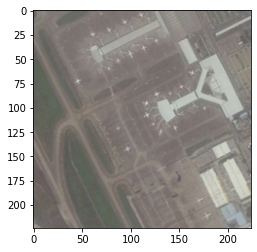

In [9]:
test_image = Image.fromarray(plt.imread(os.path.join(IMAGES_DIR, image_filename)))
plt.imshow(test_image)

In [10]:
test_sentences = ["An arial photograph of a {:s}".format(ct) for ct in class_types]

In [11]:
inputs = processor(text=test_sentences, 
                   images=test_image, return_tensors="jax", padding=True)
outputs = model(**inputs)

In [12]:
logits_per_image = outputs.logits_per_image
probs = jax.nn.softmax(logits_per_image, axis=-1)
probs

DeviceArray([[5.0863135e-01, 2.2028066e-02, 1.0469279e-03, 1.4564645e-04,
              2.5214376e-03, 6.0029089e-02, 1.6158769e-02, 1.3421639e-02,
              1.6476939e-02, 3.1717129e-03, 1.2603293e-02, 1.4839399e-03,
              9.7053632e-02, 5.0634140e-04, 5.4981736e-03, 2.2702507e-04,
              3.4546496e-03, 3.1099172e-02, 2.0180333e-03, 3.0189907e-04,
              9.3399324e-02, 2.2997933e-02, 1.1204317e-03, 3.3085485e-04,
              2.9146787e-02, 5.6548910e-03, 2.9013781e-02, 1.3928533e-02,
              5.6543299e-03, 8.7536854e-04]], dtype=float32)

In [13]:
class_types[np.argmax(probs)]

'airport'

In [14]:
probs_np = np.asarray(probs)[0]
probs_npi = np.argsort(-probs_np)
[(class_types[i], probs_np[i]) for i in probs_npi[0:5]]

[('airport', 0.50863135),
 ('industrial', 0.09705363),
 ('port', 0.09339932),
 ('center', 0.06002909),
 ('parking', 0.031099172)]

### Putting everything together

label: baseballfield
predictions
baseballfield        0.363
center               0.151
school               0.072
park                 0.067
church               0.065
denseresidential     0.054
sparseresidential    0.052
playground           0.038
mediumresidential    0.032
farmland             0.020


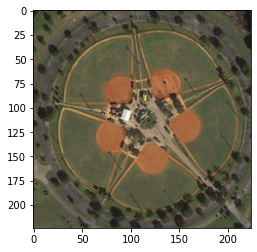

In [15]:
def predict_one_image(image_file, model, processor, class_types, k):
    label = image_file.split('_')[0]
    test_sentences = ["An arial photograph of a {:s}".format(ct) for ct in class_types]
    image = Image.fromarray(plt.imread(os.path.join(IMAGES_DIR, image_file)))
    inputs = processor(text=test_sentences,
                       images=image,
                       return_tensors="jax",
                       padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = jax.nn.softmax(logits_per_image, axis=-1)
    probs_np = np.asarray(probs)[0]
    probs_npi = np.argsort(-probs_np)
    predictions = [(class_types[i], probs_np[i]) for i in probs_npi[0:k]]
    return label, predictions


test_image = list(image2captions.keys())[100]
label, preds = predict_one_image(test_image, model, processor, class_types, 10)

image = Image.fromarray(plt.imread(os.path.join(IMAGES_DIR, test_image)))
plt.imshow(image)

print("label:", label)
print("predictions")
for class_type, class_prob in preds:
    print("{:20s} {:.3f}".format(class_type, class_prob))

In [16]:
num_predicted = 0
fres = open(EVAL_RESULTS, "w")
for image_file, _ in image2captions.items():
    if num_predicted % 100 == 0:
        print("{:d} images processed".format(num_predicted))
#     print("predicting class of image:", image_file)
    label, preds = predict_one_image(image_file, model, processor, class_types, 10)
    fres.write("{:s}\t{:s}\t{:s}\n".format(
        image_file, label, "\t".join(["{:s}\t{:.5f}".format(c, p) for c, p in preds])))
    num_predicted += 1

print("{:d} images processed, COMPLETE".format(num_predicted))
fres.close()

0 images processed
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
800 images processed
900 images processed
1000 images processed
1027 images processed, COMPLETE


1